In [46]:
import sys, os
from fractions import Fraction
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ms3 import transform, name2fifths, fifths2pc
sys.path.append(os.path.abspath('../python_scripts/'))
from data_types import ChordType, PitchType
from utils import get_chord_pitches
from constants import TRIAD_REDUCTION
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

def vc(S):
    """Value counts & normalized column"""
    vc = S.value_counts(dropna=False)
    return pd.concat([vc, vc / vc.sum()], axis=1, keys=['counts', 'fraction'])

In [2]:
data = '../Data/Beethoven_sonata_progression/'
csv_files = os.listdir(data)
fnames = [os.path.splitext(f)[0] for f in csv_files]
csv_paths = [os.path.join(data, f) for f in csv_files]
dtypes = dict(binary=bool, vl=int)
to_frac = lambda f: Fraction(f).limit_denominator(8)
converters = dict(tbt=to_frac)
D = pd.concat([pd.read_csv(p, dtype=dtypes, converters=converters) for p in csv_paths], keys=fnames).sort_index()
D.head()

time annotation1_chord annotation2_chord  sps  vl tbt  binary
01-1 0  0.00      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     1  0.25      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     2  0.50      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     3  0.75      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     4  1.00      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False

### Durations or counts?
Set `delete_repetitions` to False to have the notebook account for the durations of divergences.

Set it to True if you only care about their counts. In this case you will see the new proportion between identical and diverging labels.

In [3]:
delete_repetitions = True

if delete_repetitions:
    changed1 = D.annotation1_chord != D.annotation1_chord.shift()
    changed2 = D.annotation2_chord != D.annotation2_chord.shift()
    D = D[changed1 | changed2]
    print(D.binary.value_counts(normalize=True))

False    0.558847
True     0.441153
Name: binary, dtype: float64


### Data Expansion

In [4]:
df = D[D.binary] # select only diverging
regex = r"^([A-G](b*|#*)?)_(.*)_inv(\d)$"
def is_triad(type_str):
    val = ChordType[type_str]
    return val.value < 4
df = D[D.binary]
for n, col in ((1, 'annotation1_chord'), (2, 'annotation2_chord')):
    renaming = {0: f"root{n}", 2: f"type{n}", 3: f"inv{n}", 'triad': f"triad{n}", 'tpc': f"tpc{n}", 'pc': f"pc{n}"}
    expanded = df[col].str.extract(regex).loc[:, [0, 2, 3]]
    expanded['triad'] = transform(expanded[2], is_triad)
    expanded['tpc'] = transform(expanded[0], name2fifths)
    expanded['pc'] = transform(expanded.tpc, fifths2pc)
    df = pd.concat([df, expanded.rename(columns=renaming)], axis=1)

In [5]:
def tbt_relaxed(set_a, set_b, as_distance=False):
    """Tone-by-tone but normalizing by 3 if a triad is involved.
    Returns 1 if a triad is contained in a tetrad.
    """
    n = min(len(set_a), len(set_b))
    overlap = len(set_a.intersection(set_b)) / n
    if as_distance:
        overlap = 1 - overlap
    return Fraction(overlap).limit_denominator(n)
    
def tbt_relaxed_cacheable(pc1, pc2, type1, type2, as_distance=False):
    a = set(get_chord_pitches(pc1, ChordType[type1], PitchType.MIDI) % 12)
    b = set(get_chord_pitches(pc2, ChordType[type2], PitchType.MIDI) % 12)
    return tbt_relaxed(a, b, as_distance=as_distance)

overlap = transform(df, tbt_relaxed_cacheable, ['pc1', 'pc2', 'type1', 'type2']).rename('overlap')
df = pd.concat([df,
                (df.tpc1-df.tpc2).abs().rename('tpc_iv'), 
                (df.pc1 - df.pc2).abs().rename('pc_iv'),
                overlap,
               ], axis=1)
df.pc_iv = df.pc_iv.where(df.pc_iv <= 6, 12 - df.pc_iv)
df.head()

time  annotation1_chord annotation2_chord       sps  vl  tbt  \
01-1 30   5.25  E_DIMINISHED_inv1   C_MAJ_MIN7_inv2  0.049170   2  3/8   
     43   7.25       C_MAJOR_inv0   C_MAJ_MIN7_inv0  0.006025   2  1/8   
     56  10.25   Db_MAJ_MAJ7_inv3  Db_MAJ_MAJ7_inv1  0.075546  15  1/4   
     87  16.00      Ab_MAJOR_inv1     Eb_MAJOR_inv0  0.447499  12  6/7   
     95  18.00      Ab_MAJOR_inv1     Eb_MAJOR_inv0  0.447499  12  6/7   

         binary root1       type1 inv1  ...  pc1  root2     type2 inv2 triad2  \
01-1 30    True     E  DIMINISHED    1  ...    4      C  MAJ_MIN7    2  False   
     43    True     C       MAJOR    0  ...    0      C  MAJ_MIN7    0  False   
     56    True    Db    MAJ_MAJ7    3  ...    1     Db  MAJ_MAJ7    1  False   
     87    True    Ab       MAJOR    1  ...    8     Eb     MAJOR    0   True   
     95    True    Ab       MAJOR    1  ...    8     Eb     MAJOR    0   True   

        tpc2  pc2  tpc_iv  pc_iv  overlap  
01-1 30    0    0       4      4        1  
     43    0    0       0      0        1  
     56   -5    1       0      0        1  
     87   -3    3       1      5      1/3  
     95   -3    3       1      5      1/3  

[5 rows x 22 columns]

### SPS by shared tones ('relaxed tbt')
Maximum overlap is the minimum number of tones between the two chords, so if a triad's notes are all included in a tetrad, the overlap is 1.

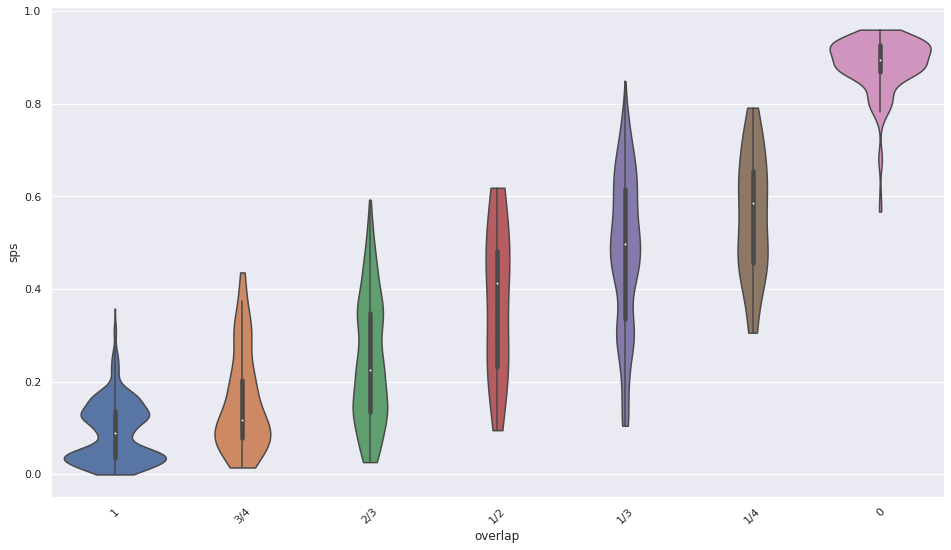

In [6]:
sns.set(rc={"figure.figsize":(16, 9)})
sns.violinplot(data=df, x='overlap', y='sps', order=sorted(df.overlap.unique(), reverse=True), cut=0)
plt.xticks(rotation=45)
plt.show()

### Categorize divergences

**Create boolean masks**

In [7]:
def reduce_tetrad(type_str):
    val = ChordType[type_str]
    return TRIAD_REDUCTION[val]

same_type_reduced = transform(df.type1, reduce_tetrad) == transform(df.type2, reduce_tetrad)
same_root = df.pc_iv == 0
same_type = df.type1 == df.type2
same_inversion = df.inv1 == df.inv2
diverging_inv = same_root & same_type
diverging_type = same_root & same_inversion

In [62]:
ctgs = pd.Series(index=df.index, dtype='string', name='divergence')
triad_tetrad = same_root & same_type_reduced & (df.triad1 != df.triad2) # the latter part was missing in the first version of the plots. It ensures that only one is a triad
triad_tetrad_root = overlap == 1
both_triads = df.triad1 & df.triad2
selectors = (
    ('inversion', diverging_inv),
    ('triad-tetrad', triad_tetrad & same_inversion),
    ('triad-tetrad & inversion', triad_tetrad & ~same_inversion),
    ('type', diverging_type),
    ('type & inversion', same_root),
    ('triad-tetrad & root', triad_tetrad_root),
    ('no_overlap', overlap == 0),
    ('tetrads_sharing_3', overlap == 3/4),
    ('tetrads_sharing_2', overlap == 1/2),
    ('tetrads_sharing_1', overlap== 1/4),
    ('triads_sharing_2',  (overlap == Fraction(2,3)) & both_triads),
    ('triad_tetrad_sharing_2', (overlap == Fraction(2,3)) & ~both_triads),
    ('triads_sharing_1', (overlap == Fraction(1,3)) & both_triads),
    ('triad_tetrad_sharing_1', (overlap == Fraction(1,3)) & ~both_triads),
    )
for c, sel in selectors:
    ctgs = ctgs.where(ctgs.notna(), sel.map({True: c, False: pd.NA}))
## Now, fill in the uncategorized with the fraction of diverging notes
tbt_rel = transform(df, tbt_relaxed_cacheable, ['pc1', 'pc2', 'type1', 'type2'], as_distance=True)
ctgs = ctgs.where(ctgs.notna(), tbt_rel.astype(str))
vc(ctgs)

,counts,fraction
inversion,944,0.284252
triads_sharing_1,547,0.164709
triad-tetrad,407,0.122553
triad_tetrad_sharing_1,290,0.087323
no_overlap,249,0.074977
triads_sharing_2,187,0.056308
triad_tetrad_sharing_2,174,0.052394
triad-tetrad & root,163,0.049082
triad-tetrad & inversion,122,0.036736
type,93,0.028004


#### SPS distributions for the different categories

In [63]:
order_by_median = df.groupby(ctgs).sps.median().sort_values().index.to_list()
labels = [f"{l} ({ctgs.value_counts(normalize=True)[l]:.1%})" for l in order_by_median]

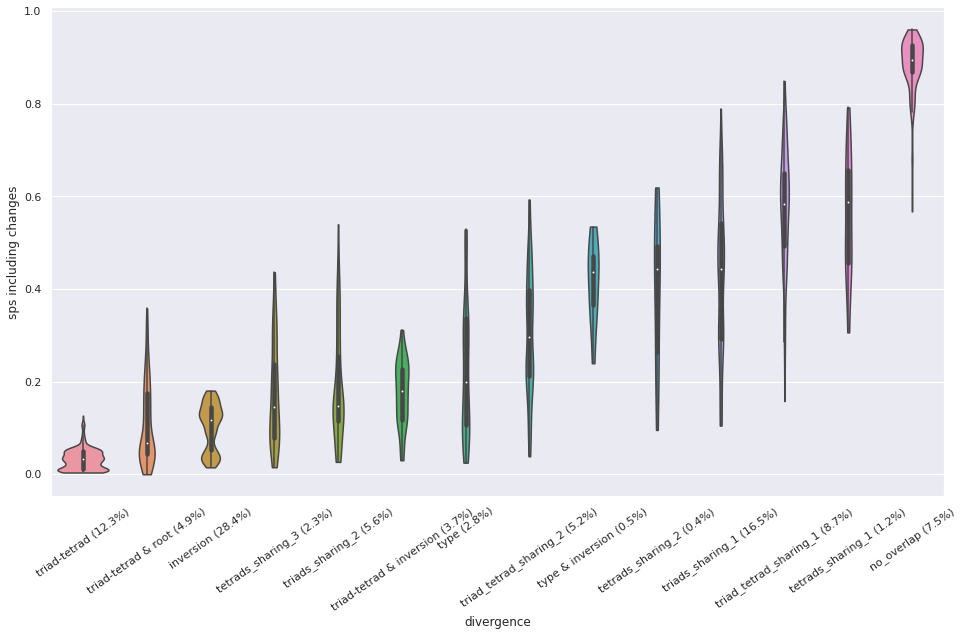

In [64]:
sns.set(rc={"figure.figsize":(16, 9)})
ax = sns.violinplot(data=df, x=ctgs, y='sps', order=order_by_median, cut=0)
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
plt.ylabel('sps including changes')
plt.savefig('../figures/categories_sps_with_changes.png', bbox_inches='tight')
plt.show()

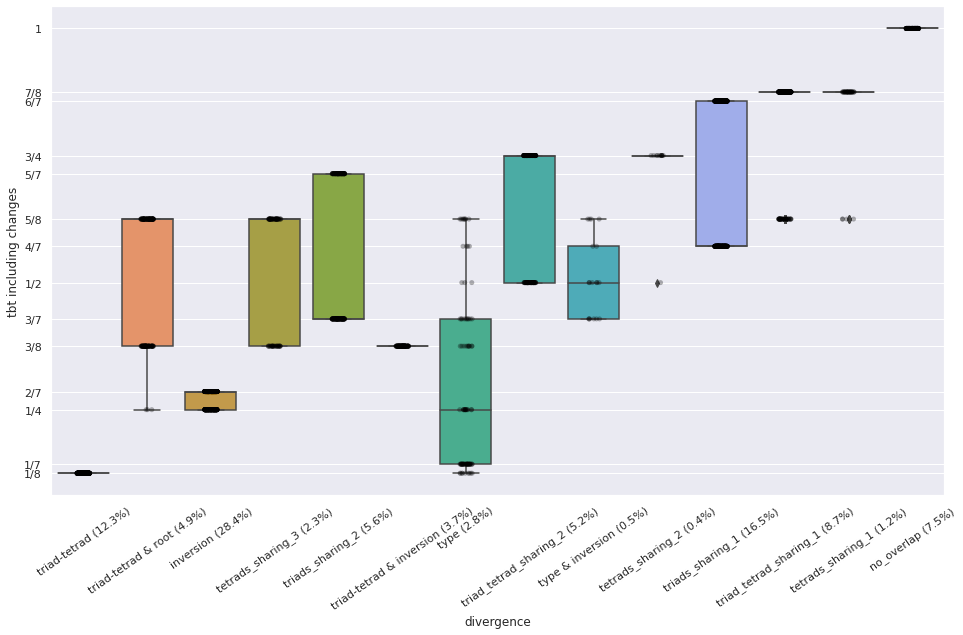

In [65]:
ax = sns.boxplot(data=df, x=ctgs, y='tbt', order=order_by_median)
ax = sns.stripplot(data=df, x=ctgs, y='tbt', order=order_by_median, marker="o", alpha=0.3, color="black")
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
yticks = sorted(df.tbt.unique())
plt.yticks(df.tbt.astype(float).unique(), df.tbt.unique())
plt.ylabel('tbt including changes')
plt.savefig('../figures/categories_tbt_with_changes.png', bbox_inches='tight')
plt.show()

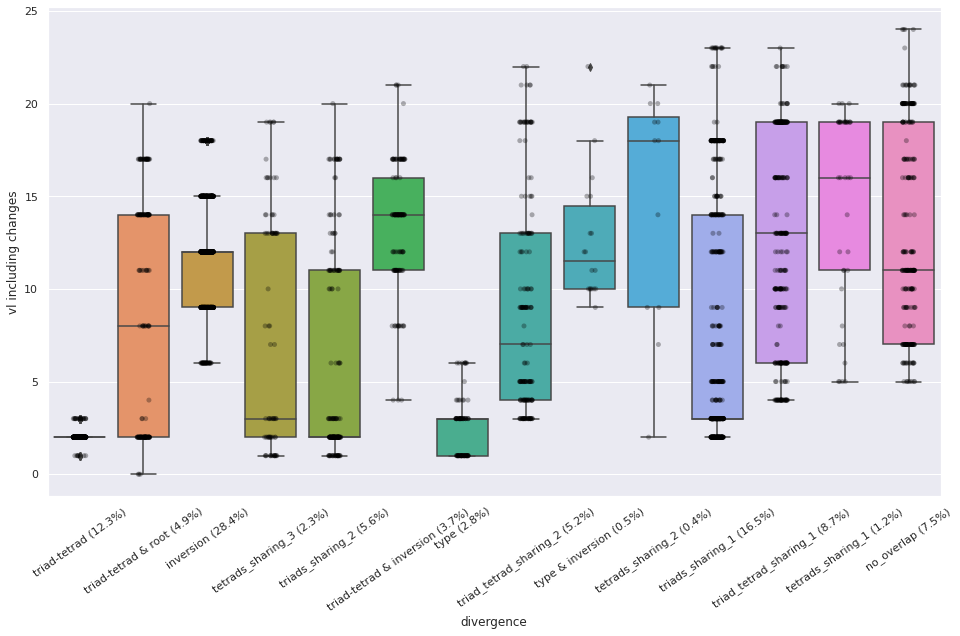

In [66]:
ax = sns.stripplot(data=df, x=ctgs, y='vl', order=order_by_median, marker="o", alpha=0.3, color="black")
ax = sns.boxplot(data=df, x=ctgs, y='vl', order=order_by_median)
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
plt.ylabel('vl including changes')
plt.savefig('../figures/categories_vl_with_changes.png', bbox_inches='tight')
plt.show()

# Combining metrics for more fine-grained error categories
## Triad-tetrad SPS divided by VL values

In [67]:
tri_tet = df[ctgs == 'triad-tetrad'].copy()
tri_tet.groupby('vl').sps.describe()

,count,mean,std,min,25%,50%,75%,max
vl,,,,,,,,
1,8.0,0.023734,0.005547,0.020385,0.020385,0.020931,0.024280,0.032689
2,379.0,0.031716,0.022832,0.003718,0.009006,0.034780,0.049487,0.126403
3,20.0,0.036153,0.010193,0.010659,0.029046,0.034622,0.045040,0.053230


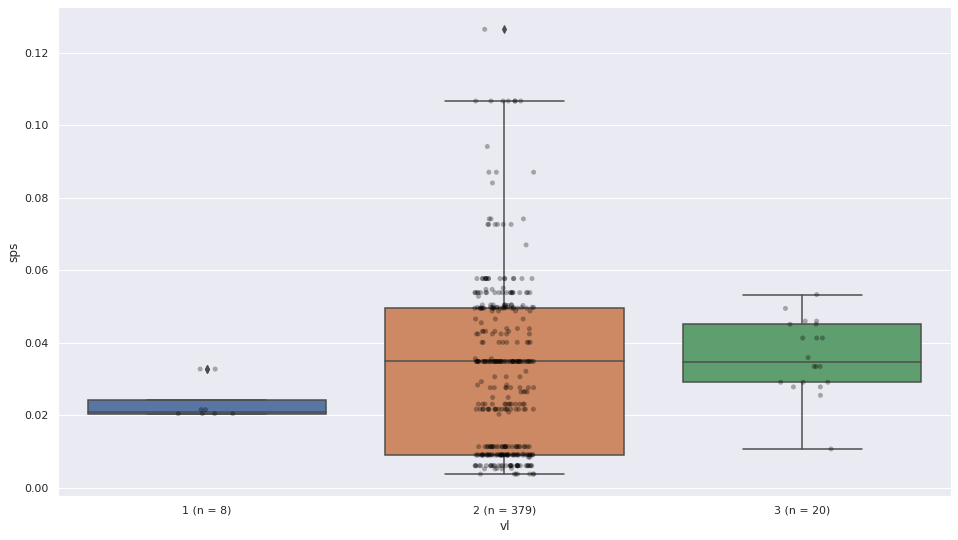

In [68]:
ax = sns.boxplot(data=tri_tet, x='vl', y='sps')
ax = sns.stripplot(data=tri_tet, x='vl', y='sps', marker="o", alpha=0.3, color="black")
ax.set_xticklabels([f"{i} (n = {n})" for i, n in tri_tet.groupby('vl').size().iteritems()])
plt.show()

In [69]:
comparisons = ('tpc', 'pc', 'type', 'inv', 'triad') 
tri_tet_groups = {compare: tri_tet[[f"{compare}1", f"{compare}2"]].apply(lambda row: tuple(sorted(row)), axis=1) for compare in comparisons}

### Chord type combinations for the different VL values
Chord combinations in this category share the same root, inversion, and reduced chord type.

In [71]:
tri_tet.groupby([tri_tet.vl, tri_tet_groups['type']]).size()

vl                         
1   (MAJOR, MAJ_MAJ7)            8
2   (DIMINISHED, HALF_DIM7)     13
    (MAJOR, MAJ_MIN7)          351
    (MINOR, MIN_MIN7)           15
3   (DIM7, DIMINISHED)          20
dtype: int64

**The three different VL values seem to be dependent on the size of the 7th**

In [78]:
tri_tet.groupby([tri_tet.vl, tri_tet_groups['type'], tri_tet_groups['inv']]).sps.describe()

count      mean       std       min  \
vl                                                                       
1  (MAJOR, MAJ_MAJ7)       (0, 0)    4.0  0.020385  0.000000  0.020385   
                           (1, 1)    4.0  0.027083  0.006472  0.021478   
2  (DIMINISHED, HALF_DIM7) (0, 0)    7.0  0.018123  0.017845  0.005145   
                           (1, 1)    6.0  0.032331  0.007191  0.026358   
   (MAJOR, MAJ_MIN7)       (0, 0)  247.0  0.021717  0.015125  0.003718   
                           (1, 1)   78.0  0.048260  0.011258  0.026506   
                           (2, 2)   26.0  0.076654  0.026730  0.032067   
   (MINOR, MIN_MIN7)       (0, 0)   10.0  0.028837  0.020726  0.005288   
                           (1, 1)    3.0  0.050205  0.037991  0.028271   
                           (2, 2)    2.0  0.069524  0.020499  0.055029   
3  (DIM7, DIMINISHED)      (0, 0)    7.0  0.030721  0.012248  0.010659   
                           (1, 1)    9.0  0.036782  0.007861  0.027760   
                           (2, 2)    4.0  0.044246  0.005989  0.041251   

                                        25%       50%       75%       max  
vl                                                                         
1  (MAJOR, MAJ_MAJ7)       (0, 0)  0.020385  0.020385  0.020385  0.020385  
                           (1, 1)  0.021478  0.027082  0.032687  0.032689  
2  (DIMINISHED, HALF_DIM7) (0, 0)  0.005145  0.009251  0.024711  0.052754  
                           (1, 1)  0.026366  0.030969  0.035547  0.043788  
   (MAJOR, MAJ_MIN7)       (0, 0)  0.009006  0.021602  0.034780  0.049702  
                           (1, 1)  0.040051  0.052070  0.053767  0.074106  
                           (2, 2)  0.054659  0.072585  0.106622  0.126403  
   (MINOR, MIN_MIN7)       (0, 0)  0.008361  0.033137  0.048700  0.048700  
                           (1, 1)  0.028271  0.028271  0.061172  0.094073  
                           (2, 2)  0.062277  0.069524  0.076772  0.084019  
3  (DIM7, DIMINISHED)      (0, 0)  0.027242  0.029046  0.037476  0.045907  
                           (1, 1)  0.033386  0.033386  0.045040  0.049418  
                           (2, 2)  0.041251  0.041251  0.044246  0.053230

In [75]:
tri_tet[(tri_tet.vl == 3) & (tri_tet_groups['tpc'] == (-1, -1))]

time  annotation1_chord annotation2_chord       sps  vl  tbt  \
09-1 1090  130.75  F_DIMINISHED_inv1       F_DIM7_inv1  0.035858   3  1/8   
24-1 598    49.50  F_DIMINISHED_inv0       F_DIM7_inv0  0.045907   3  1/8   
     626    51.25  F_DIMINISHED_inv0       F_DIM7_inv0  0.045907   3  1/8   

           binary root1       type1 inv1  triad1  tpc1  pc1 root2 type2 inv2  \
09-1 1090    True     F  DIMINISHED    1    True    -1    5     F  DIM7    1   
24-1 598     True     F  DIMINISHED    0    True    -1    5     F  DIM7    0   
     626     True     F  DIMINISHED    0    True    -1    5     F  DIM7    0   

           triad2  tpc2  pc2  tpc_iv  pc_iv overlap  
09-1 1090   False    -1    5       0      0       1  
24-1 598    False    -1    5       0      0       1  
     626    False    -1    5       0      0       1

# Older code
#### Checking outliers

In [13]:
df[ctgs == 'triads_sharing_1'].groupby('vl').sps.min()

vl
2     0.105133
3     0.116758
4     0.270048
5     0.314954
7     0.316380
8     0.400738
9     0.390535
12    0.414226
13    0.480975
14    0.381390
15    0.346073
16    0.583396
17    0.403210
18    0.411279
19    0.568610
22    0.396430
23    0.636311
Name: sps, dtype: float64

In [14]:
df[(ctgs == 'triads_sharing_1') & (df.vl <= 3)]

time annotation1_chord annotation2_chord       sps  vl  tbt  \
01-1 218    34.25000     Eb_MAJOR_inv0     Ab_MAJOR_inv2  0.149890   3  4/7   
     250    38.25000     Eb_MAJOR_inv0     Ab_MAJOR_inv2  0.149890   3  4/7   
     271    41.25000     Eb_MAJOR_inv0     Ab_MAJOR_inv2  0.149890   3  4/7   
     281    43.25000     Eb_MAJOR_inv0     Ab_MAJOR_inv2  0.149890   3  4/7   
     291    45.25000     Eb_MAJOR_inv0     Ab_MAJOR_inv2  0.149890   3  4/7   
...              ...               ...               ...       ...  ..  ...   
32-1 1445  117.28125      G_MAJOR_inv0      C_MAJOR_inv2  0.496722   3  4/7   
     1501  123.03125      C_MAJOR_inv0      F_MINOR_inv2  0.334639   2  4/7   
     1709  136.53125      G_MAJOR_inv0      C_MINOR_inv2  0.501203   2  4/7   
     1717  137.03125      G_MAJOR_inv0      C_MINOR_inv2  0.501203   2  4/7   
     1765  140.03125      G_MAJOR_inv0      C_MINOR_inv2  0.501203   2  4/7   

           binary root1  type1 inv1  ...  pc1  root2  type2 inv2 triad2 tpc2  \
01-1 218     True    Eb  MAJOR    0  ...    3     Ab  MAJOR    2   True   -4   
     250     True    Eb  MAJOR    0  ...    3     Ab  MAJOR    2   True   -4   
     271     True    Eb  MAJOR    0  ...    3     Ab  MAJOR    2   True   -4   
     281     True    Eb  MAJOR    0  ...    3     Ab  MAJOR    2   True   -4   
     291     True    Eb  MAJOR    0  ...    3     Ab  MAJOR    2   True   -4   
...           ...   ...    ...  ...  ...  ...    ...    ...  ...    ...  ...   
32-1 1445    True     G  MAJOR    0  ...    7      C  MAJOR    2   True    0   
     1501    True     C  MAJOR    0  ...    0      F  MINOR    2   True   -1   
     1709    True     G  MAJOR    0  ...    7      C  MINOR    2   True    0   
     1717    True     G  MAJOR    0  ...    7      C  MINOR    2   True    0   
     1765    True     G  MAJOR    0  ...    7      C  MINOR    2   True    0   

           pc2  tpc_iv  pc_iv  overlap  
01-1 218     8       1      5      1/3  
     250     8       1      5      1/3  
     271     8       1      5      1/3  
     281     8       1      5      1/3  
     291     8       1      5      1/3  
...        ...     ...    ...      ...  
32-1 1445    0       1      5      1/3  
     1501    5       1      5      1/3  
     1709    0       1      5      1/3  
     1717    0       1      5      1/3  
     1765    0       1      5      1/3  

[283 rows x 22 columns]

In [15]:
df[ctgs == 'triads_sharing_1'].sort_values('sps')

time annotation1_chord annotation2_chord       sps  vl  tbt  \
17-1 598    75.00      E_MAJOR_inv0      A_MINOR_inv2  0.105133   2  4/7   
09-1 1138  136.50      E_MAJOR_inv0      A_MINOR_inv2  0.105133   2  4/7   
17-1 654    82.00      E_MAJOR_inv0      A_MINOR_inv2  0.105133   2  4/7   
     412    44.00      E_MAJOR_inv0      A_MINOR_inv2  0.105133   2  4/7   
     420    45.00      E_MAJOR_inv0      A_MINOR_inv2  0.105133   2  4/7   
...           ...               ...               ...       ...  ..  ...   
07-1 539    94.75      A_MAJOR_inv2      D_MAJOR_inv0  0.758438   9  6/7   
16-1 34      5.50      F_MAJOR_inv0      D_MAJOR_inv0  0.774035  12  6/7   
07-1 1831  323.00     Gb_MAJOR_inv1      B_MINOR_inv0  0.775498   4  6/7   
09-1 194    26.50      B_MAJOR_inv0     Gb_MAJOR_inv1  0.788415   5  6/7   
     232    34.50      B_MAJOR_inv0     Gb_MAJOR_inv1  0.788415   5  6/7   

           binary root1  type1 inv1  ...  pc1  root2  type2 inv2 triad2 tpc2  \
17-1 598     True     E  MAJOR    0  ...    4      A  MINOR    2   True    3   
09-1 1138    True     E  MAJOR    0  ...    4      A  MINOR    2   True    3   
17-1 654     True     E  MAJOR    0  ...    4      A  MINOR    2   True    3   
     412     True     E  MAJOR    0  ...    4      A  MINOR    2   True    3   
     420     True     E  MAJOR    0  ...    4      A  MINOR    2   True    3   
...           ...   ...    ...  ...  ...  ...    ...    ...  ...    ...  ...   
07-1 539     True     A  MAJOR    2  ...    9      D  MAJOR    0   True    2   
16-1 34      True     F  MAJOR    0  ...    5      D  MAJOR    0   True    2   
07-1 1831    True    Gb  MAJOR    1  ...    6      B  MINOR    0   True    5   
09-1 194     True     B  MAJOR    0  ...   11     Gb  MAJOR    1   True   -6   
     232     True     B  MAJOR    0  ...   11     Gb  MAJOR    1   True   -6   

           pc2  tpc_iv  pc_iv  overlap  
17-1 598     9       1      5      1/3  
09-1 1138    9       1      5      1/3  
17-1 654     9       1      5      1/3  
     412     9       1      5      1/3  
     420     9       1      5      1/3  
...        ...     ...    ...      ...  
07-1 539     2       1      5      1/3  
16-1 34      2       3      3      1/3  
07-1 1831   11      11      5      1/3  
09-1 194     6      11      5      1/3  
     232     6      11      5      1/3  

[547 rows x 22 columns]

In [16]:
def get_value_pair(row, col):
    """Return value pairs such that the first one belongs to the lower of both roots."""
    col1, col2 = f"{col}1", f"{col}2"
    if (row.pc1 + row.pc_iv) % 12 != row.pc2:
        return row[col2], row[col1]
    return row[col1], row[col2]

### Inspect particular divergences
#### Two seventh chords with different roots and 3 common tones
For example, the first row, `1  (MAJ_MIN7, DIM7)  4` means: 4 instances of a dominant 7th chord and a diminished 7th chord with the root 1 semitone higher than the former.

In [17]:
tetrads_sharing_3 = df[ctgs == 'tetrads_sharing_3']
type_groups = tetrads_sharing_3.apply(get_value_pair, col='type', axis=1).rename('types')
tetrads_sharing_3 = pd.concat([tetrads_sharing_3, type_groups], axis=1)
tetrads_sharing_3.groupby(['pc_iv', 'types']).size()

pc_iv  types                
1      (MAJ_MIN7, DIM7)          4
2      (DIM7, MAJ_MIN7)          1
3      (DIM7, HALF_DIM7)         8
       (HALF_DIM7, MIN_MIN7)     2
       (MIN_MIN7, MAJ_MAJ7)      4
       (MIN_MIN7, MAJ_MIN7)      1
4      (MAJ_MIN7, DIM7)         38
       (MAJ_MIN7, HALF_DIM7)    18
dtype: int64

#### Two triads with different roots and 2 common tones

In [18]:
triads_sharing_2 = df[ctgs == 'triads_sharing_2']
# here, the order of types is always (lower_root, higher_root)
type_groups = triads_sharing_2.apply(get_value_pair, col='type', axis=1).rename('types')
triads_sharing_2 = pd.concat([triads_sharing_2, type_groups], axis=1)
triads_sharing_2.groupby(['pc_iv', 'types']).size()

pc_iv  types                   
1      (MAJOR, DIMINISHED)          8
3      (DIMINISHED, DIMINISHED)     2
       (DIMINISHED, MINOR)         31
       (MINOR, AUGMENTED)           4
       (MINOR, MAJOR)              75
4      (MAJOR, DIMINISHED)         24
       (MAJOR, MINOR)              43
dtype: int64